__1. Выберите наборы данных. которые можно интерпретировать, как временные ряды:__

    а) зависимость цены на недвижимость в конкретном регионе от времени,
    
    б) скорость полета самолета при перелете из аэропорта А в аэропорт В,
    
    в) количество отказов компьютера,
    
    г) число обращений в поликлинику по району,
    
    д) координаты автобуса при движении по маршруту,
  
    е) координаты фигуры нарушителя в файле видеофиксации охранной системы.

Многие наборы данных можно интерпретировать как временные ряды, но с определенными условиями:

    а) если за временной период взять месяцы или годы, иначе временной ряд будет не информативен;
    
    б) да, все записи бортового самописца, кроме разовых команд можно интерпретировать как временные ряды;
    
    в) только за определенный период (за день, неделю, месяц, год и при нескольких измеренях (за прошлый и текущий год, к примеру));
    
    г) тоже за определенный период (обращений в день);
    
    д) в чистом виде нет, т.к. данные независимы от времени;
    
    е) тоже нет, тз-за независимости о времени.

__2. Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Количество пропусков: 0
Количество дублей даты: 4
Даты отсортированы: False

Даты дубликаты:
2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
Name: Datetime, dtype: int64

Даты с пропущенным часом (3:00):
0    2017-03-12
1    2014-03-09
2    2015-03-08
3    2016-03-13
dtype: object


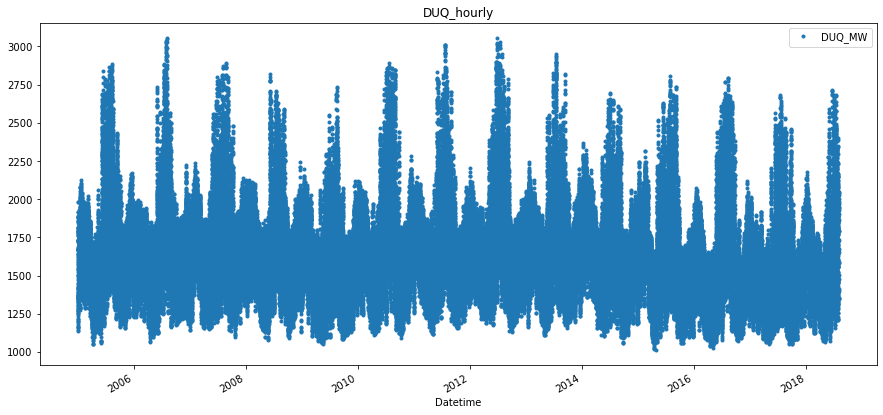

In [2]:
data = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])

print(f"Количество пропусков: {data['DUQ_MW'].isnull().sum()}")

n_dupl = np.abs(data.index.unique().shape[0] - data.shape[0])
dupl_lst = data.index.value_counts().head(n_dupl)

print(f"Количество дублей даты: {n_dupl}")
print(f"Даты отсортированы: {all(data.index==data.sort_index().index)}")
print(f"\nДаты дубликаты:\n{dupl_lst}\n" if n_dupl else '')

miss_hour_days = []
for year in [date.year for date in dupl_lst.index]:
    day_count = data[f'{year}-03-01 00:00:00':f'{year}-03-31 23:00:00'].index.day.value_counts()
    miss_hour_days.append(data.index.date[(data.index.day == day_count[day_count != 24].index[0]) &
                                          (data.index.year == year) &
                                          (data.index.month == 3)][0])

miss_date = pd.Series(miss_hour_days)
miss_hour = data.index.hour.value_counts().tail(1).index[0]

print(f"Даты с пропущенным часом ({miss_hour}:00):\n{miss_date}")

data.plot(style='.', figsize=( 15, 7 ), title='DUQ_hourly');

Пропусков и необычных выбросов в данных нет, данные цикличны, даты не отсортированы. С 2014 по 2017 присутствуют по одному дибликату и одному пропущенному значению времени, что можно объяснить сезонным переводом часов (декретным временем).

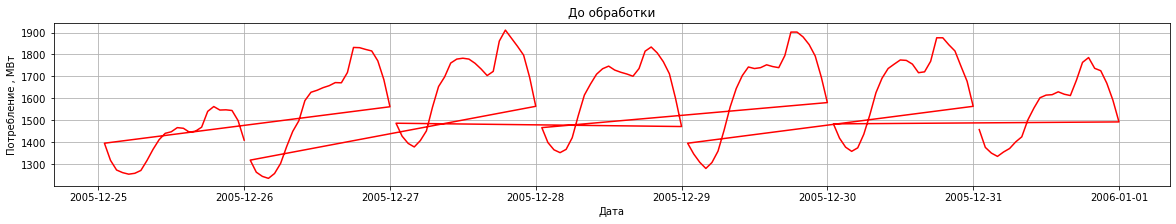

In [3]:
n_days = 7

plt.figure(figsize=(20,3))
plt.plot(data[0:n_days*24].index, data[0:n_days*24].values, 'r')

plt.xlabel('Дата')
plt.ylabel('Потребление , МВт')
plt.title('До обработки')
plt.grid()
plt.show()

In [4]:
# заполним пропуски по 2 соседям
for value in miss_date:
    data.loc[pd.to_datetime(f'{str(value)} {miss_hour}:00:00')] = \
    (data[f'{str(value)} {miss_hour + 1}:00:00']['DUQ_MW'].values + 
     data[f'{str(value)} {miss_hour - 1}:00:00']['DUQ_MW'].values) / 2
# удалим дубликаты
data = data.loc[np.invert(data.index.duplicated(keep='first'))]
# отсортируем по дате
data = data.sort_index()

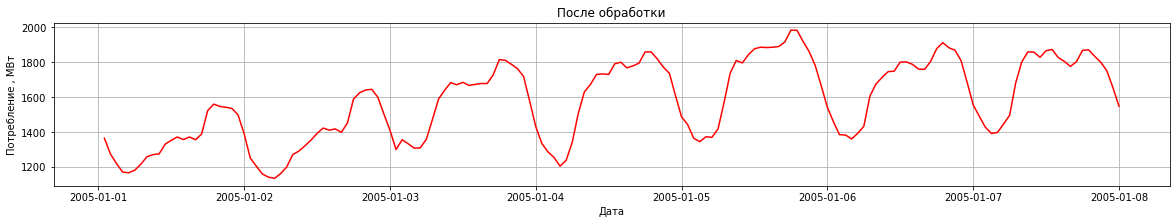

In [5]:
n_days = 7

plt.figure(figsize=(20,3))
plt.plot(data[0:n_days*24].index, data[0:n_days*24].values, 'r')

plt.xlabel('Дата')
plt.ylabel('Потребление , МВт')
plt.title('После обработки')
plt.grid()
plt.show()

__3. Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам.__

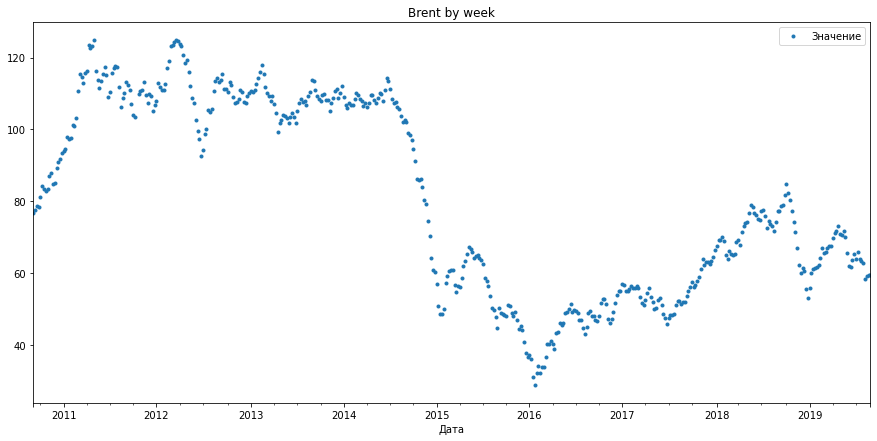

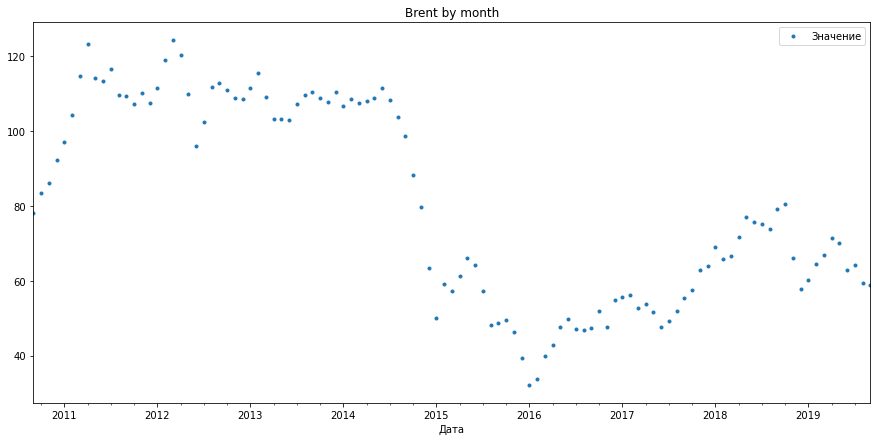

In [6]:
brent_data = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])

brent_data_week = brent_data.resample("W").mean()
brent_data_month = brent_data.resample("M").mean()
brent_data_year = brent_data.resample("Y").mean()

brent_data_week.plot(style='.', figsize=(15, 7), title='Brent by week')
brent_data_month.plot(style='.', figsize=(15, 7), title='Brent by month');

__4. Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.__

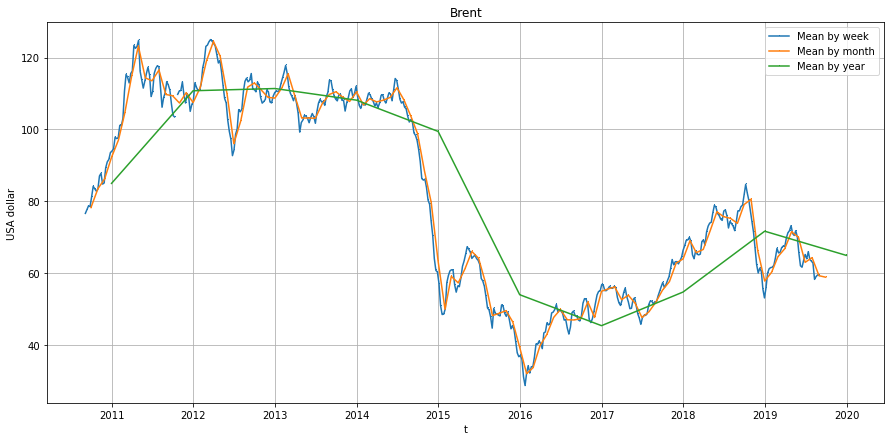

In [7]:
plt.figure(figsize=(15,7))
plt.plot(brent_data_week, label='Mean by week', marker=',')
plt.plot(brent_data_month, label='Mean by month', marker=',')
plt.plot(brent_data_year, label='Mean by year', marker=',')
plt.xlabel('t')
plt.ylabel('USA dollar')
plt.title('Brent')
plt.legend()
plt.grid()

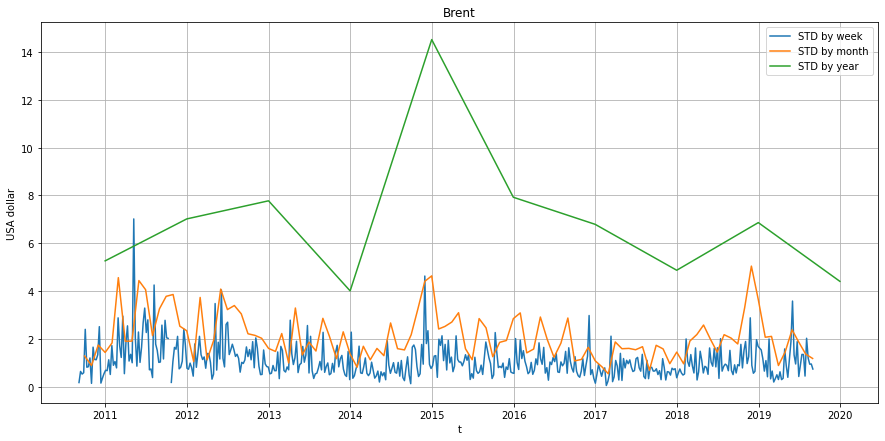

In [8]:
plt.figure(figsize=(15,7))
plt.plot(brent_data.resample("W").std(), label='STD by week')
plt.plot(brent_data.resample("M").std(), label='STD by month')
plt.plot(brent_data.resample("Y").std(), label='STD by year')
plt.xlabel('t')
plt.ylabel('USA dollar')
plt.title('Brent')
plt.legend()
plt.grid()

__5. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.__

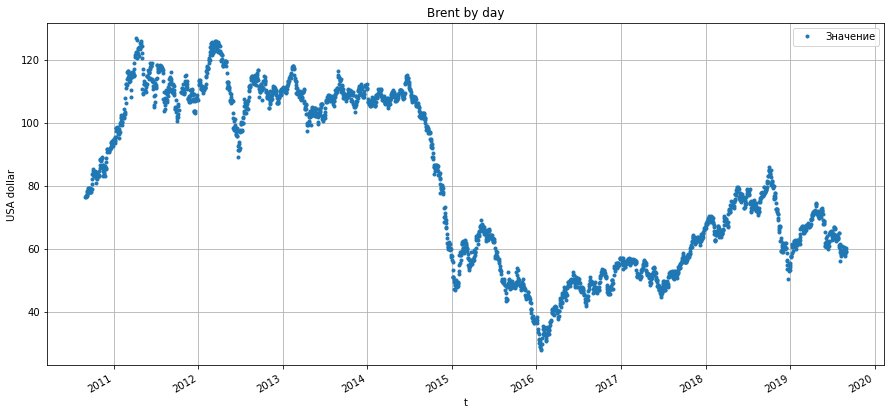

In [9]:
brent_data.plot( style='.', figsize=(15, 7), title='Brent by day', marker='.')
plt.ylabel('USA dollar')
plt.grid()
plt.xlabel('t');

С уменьшением частоты наблюдений (увеличение периода) уменьшается количество выбросов, график становиться более плавным (аппроксимация) и увеличивается СКО, флуктуации цены становяться меньше с увеличением периода.
Для исключения потери информации увеличивать период наблюдений стоит только при увеличении общего анализируемого периода.